In [55]:
##library
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import random
import gzip
import shutil
from Bio import SeqIO
import pickle
import subprocess
from subprocess import Popen, PIPE
import seaborn as sns
from Levenshtein import distance as lev
from Bio import pairwise2
from Bio.Seq import Seq
from scipy.spatial.distance import hamming

In [2]:
#####parse pickle
GFF3_codg=pd.read_pickle("./GFF3_codg.pkl")
GFF3_psdg=pd.read_pickle("./GFF3_psdg.pkl")
GFF3_ext=pd.read_pickle("./GFF3_ext.pkl")
with open("FASTA_orig.pickle", 'rb') as handle:
    FASTA_orig= pickle.load(handle)
######

In [186]:
##input variables
GFF3_file="./Homo_sapiens.GRCh38.110.gff3"
FASTA_file="./homo_sapiens_grch38_dna_primary_assembly_fa.gz"

In [34]:
##download gff3 and open archive #source https://ftp.ensembl.org/pub/release-110/gff3/homo_sapiens/Homo_sapiens.GRCh38.110.gff3.gz
##read as tab-separated file
GFF3_orig=pd.read_csv(GFF3_file, sep='\t',skiprows=200,header=None) ##skip comments rows
##be aware that there are len(GFF3_orig[GFF3_orig[0]=="###"])==62948 commented rows. I will delet them in GFF3_ext

In [135]:
GFF3_ext=GFF3_orig.copy()

In [136]:
##delet comment rows
GFF3_ext=GFF3_ext[GFF3_ext[0]!="###"]

In [137]:
##add column names
GFF3_ext=GFF3_ext.rename(columns={0: "seqid", 1: "source",2:"type",3:"start",4:"end",5:"score",6:"strand",7:"phase",8:"attributes"})
feature_cols=['ID','biotype','gene_id','Name','description','Parent','transcript_id','exon_id',"constitutive",'rank','protein_id']
GFF3_ext = GFF3_ext.reindex(columns = GFF3_ext.columns.tolist()+feature_cols)

In [138]:
##parse needed features: ID;biotype,gene_id,Name,description(gene);Parent,transcript_id (transcript);exon_id,rank (exon);protein_id (CDS)
for ftr in feature_cols:
    print(ftr)
    print(datetime.now())
    serch="".join([ftr,"="])
    Indx=list(GFF3_ext[GFF3_ext["attributes"].str.contains(serch)].index)
    for ind in Indx: #make comprehation
        value="".join(GFF3_ext["attributes"][ind].split(serch)[1]).split(";")[0]
        GFF3_ext.at[ind, ftr]=value

ID
2023-08-14 20:19:46.631501
biotype
2023-08-14 20:20:09.827109
gene_id
2023-08-14 20:20:17.829830
Name
2023-08-14 20:20:21.238932
description
2023-08-14 20:20:55.074398
Parent
2023-08-14 20:20:58.676806
transcript_id
2023-08-14 20:21:53.214810
exon_id
2023-08-14 20:22:00.047087
constitutive
2023-08-14 20:22:28.991136
rank
2023-08-14 20:22:59.350251
protein_id
2023-08-14 20:23:26.556334


In [143]:
GFF3_ext.to_pickle("./GFF3_ext.pkl") 

In [148]:
##extract len(GFF3_ext[GFF3_ext["type"]=="pseudogene"])==15239 pseudogenes
GFF3_psdg=GFF3_ext[GFF3_ext["type"]=="pseudogene"]

In [149]:
GFF3_psdg.to_pickle("./GFF3_psdg.pkl") 

In [158]:
##http://useast.ensembl.org/Homo_sapiens/Info/Annotation say that number of coding genes=19831
len(GFF3_ext[(GFF3_ext["type"]=="gene") & (GFF3_ext["biotype"]=="protein_coding")]) ##20070
##what are other 239????

20070

In [161]:
##extract protein coding genes
GFF3_codg=GFF3_ext[(GFF3_ext["type"]=="gene") & (GFF3_ext["biotype"]=="protein_coding")]

In [164]:
GFF3_codg.to_pickle("./GFF3_codg.pkl") 

In [191]:
##download fasta and open archive ##source https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
with gzip.open(FASTA_file, 'rb') as f_in:
    with open(FASTA_file.rstrip(".gz"), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [228]:
##parce to dictionary
input_file = open(FASTA_file.rstrip(".gz"))
FASTA_orig = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

In [231]:
with open('./FASTA_orig.pickle', 'wb') as handle:
    pickle.dump(FASTA_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
##extract 10 pseudogenes and 25 coding genes for test
psdg_rnd_indx=[random.choice(GFF3_psdg.index) for i in range(0,10)]
codg_rnd_indx=[random.choice(GFF3_codg.index) for i in range(0,25)]

In [3]:
def gff3_fasta_todict(gff3_df,fasta_dict,indx="all"):
    if indx=="all":
        indx=list(gff3_df.index)
    info_dict={}
    subkey=list(gff3_df.columns)
    subkey.append("sequence")
    for ind in indx:
        name="_".join([str(gff3_df.loc[ind,"seqid"]),str(int(gff3_df.loc[ind,"start"])),str(int(gff3_df.loc[ind,"end"])),str(gff3_df.loc[ind,"Name"])])
        info_dict[name]={}
        for sk in subkey[:-1]:
            info_dict[name][sk]=gff3_df.loc[ind][sk]
        info_dict[name][subkey[-1]]=str(fasta_dict[gff3_df.loc[ind,"seqid"]][int(gff3_df.loc[ind,"start"]):int(gff3_df.loc[ind,"end"])].seq)
    return info_dict

In [34]:
psdg_rnd_seq=gff3_fasta_todict(GFF3_ext,FASTA_orig,psdg_rnd_indx)

In [36]:
codg_rnd_seq=gff3_fasta_todict(GFF3_ext,FASTA_orig,codg_rnd_indx)

In [4]:
def seq_to_fasta(seq_dict,save_dir):
    for key in seq_dict:
        filename="".join(["./",save_dir,"/",key,".fna"])
        #print(filename)
        with open(filename, "w") as file:
            header="".join([">",key,"\n"])
            seq="".join([seq_dict[key]["sequence"],"\n"])
            file.writelines([header,seq])
            file.close()

In [124]:
#seq_to_fasta(psdg_rnd_seq,"test")

In [5]:
def mash_dist(reference_seq_dict,query_seq_dict,fna_dir):
    #creat empty matrix
    #dist_matrix=np.empty([len(reference_seq_dict), len(query_seq_dict)])
    dist_dict={}
    #make sketch for reference
    ref_files=[]
    for key in reference_seq_dict:
        filename="".join(["./",fna_dir,"/",key,".fna"])
        ref_files.append(filename)
    ref_query=" ".join(ref_files)
    cmd_sketch="mash sketch -o reference "+ref_query
    ref_sketch_res=subprocess.run([cmd_sketch], shell=True, capture_output=True, text=True)
    #move referense sketch to fna dir
    refmsh=f"./{fna_dir}/{fna_dir}_reference.msh"
    subprocess.check_output([f"mv  reference.msh {refmsh}"],shell=True, text=True)
    #get info
    cmd_info=f"mash info {refmsh}"
    ref_info_res=subprocess.run([cmd_info], shell=True, capture_output=True, text=True)
    #mash dist for query
    for key in query_seq_dict:
        filename="".join(["./",fna_dir,"/",key,".fna"])
        with Popen(f"mash dist {refmsh} {filename}", shell=True, stdout=PIPE) as process:
            query_res = pd.read_csv(process.stdout,sep="\t",header=None)
        query_res.index=reference_seq_dict.keys()
        query_res=query_res.drop([0,1],axis=1)
        query_res.columns=["mshdist","p","match"]
        query_res_dict=query_res.to_dict(orient="dict")
        dist_dict[key]=query_res_dict    
    #save dict
    with open(f"./{fna_dir}/{fna_dir}_dist_dict.pickle", 'wb') as handle:
        pickle.dump(dist_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return(dist_dict,ref_info_res)

In [122]:
#dist_dict_test,ref_info_res_test=mash_dist(psdg_rnd_seq,psdg_rnd_seq,"test")

In [ ]:
##################test on GAPDH

In [6]:
#extract gapdh, 5 gapdh pseudogenes, 5 other pseudogenes
gapdhp_5=[i for i in GFF3_psdg.index if "GAPDH" in str(GFF3_psdg["Name"][i])][0:5]
gapdhg_i=GFF3_codg[GFF3_codg["Name"]=="GAPDH"].index[0]
psdg_rnd_5=[random.choice(GFF3_psdg.index) for i in range(0,5)]
psdg_gapdh_indx=[gapdhg_i]+gapdhp_5+psdg_rnd_5
#gapdh, 10 random coding genes
codg_gapdh_indx=[gapdhg_i]+[random.choice(GFF3_codg.index) for i in range(0,10)]

In [7]:
psdg_gapdh_seq=gff3_fasta_todict(GFF3_ext,FASTA_orig,psdg_gapdh_indx)


In [8]:
codg_gapdh_seq=gff3_fasta_todict(GFF3_ext,FASTA_orig,codg_gapdh_indx)

In [9]:
seq_to_fasta(psdg_gapdh_seq,"test_gapdh")
seq_to_fasta(codg_gapdh_seq,"test_gapdh")

In [10]:
dist_dict_test_gapdh,ref_info_res_test_gapdh=mash_dist(codg_gapdh_seq,psdg_gapdh_seq,"test_gapdh")

In [197]:
#print(ref_info_res_test_gapdh.stdout) #Target min-hashes per sketch:  1000 #K-mer size: 21 (64-bit hashes)

In [11]:
def distance_matrix(dist_dict,save_dir,parameter="mshdist"):
    #creat empty matrix
    reference_rows=dist_dict[list(dist_dict.keys())[0]][parameter].keys()
    query_cols=dist_dict.keys()
    dist_matrix=pd.DataFrame(index=reference_rows,columns=query_cols)
    #fill values
    for key in dist_dict:
        param_val=dist_dict[key][parameter].items()
        param_val=[tup[1] for tup in param_val]
        dist_matrix.loc[:,key]=param_val
    #save
    dist_matrix.to_pickle(f"./{save_dir}/{save_dir}_dist_matrix.pkl")
    return dist_matrix

In [12]:
dist_matrix_test_gapdh=distance_matrix(dist_dict_test_gapdh,"test_gapdh")

<AxesSubplot:>

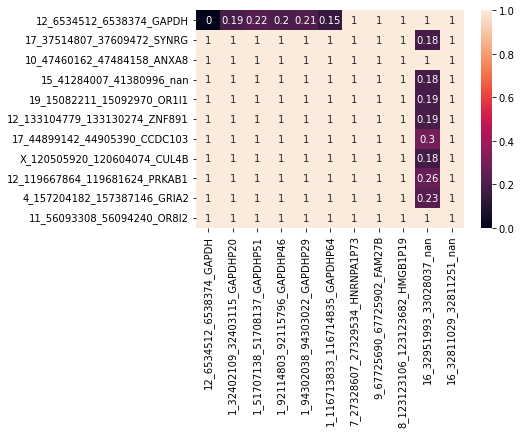

In [13]:
sns.heatmap(dist_matrix_test_gapdh, annot=True) #why ITPK1P1 is so close to unrelated genes? should I tune k-mer and sketch size?

In [14]:
def mash_dist_tune(reference_seq_dict,query_seq_dict,fna_dir,k_mer,sketch_size):
    #creat empty matrix
    dist_dict={}
    #make sketch for reference
    ref_files=[]
    for key in reference_seq_dict:
        filename="".join(["./",fna_dir,"/",key,".fna"])
        ref_files.append(filename)
    ref_query=" ".join(ref_files)
    cmd_sketch=f"mash sketch -k {k_mer} -s {sketch_size} -o reference "+ref_query
    ref_sketch_res=subprocess.run([cmd_sketch], shell=True, capture_output=True, text=True)
    #move referense sketch to fna dir
    refmsh=f"./{fna_dir}/{fna_dir}_reference.msh"
    subprocess.check_output([f"mv  reference.msh {refmsh}"],shell=True, text=True)
    #get info
    cmd_info=f"mash info {refmsh}"
    ref_info_res=subprocess.run([cmd_info], shell=True, capture_output=True, text=True)
    #mash dist for query
    for key in query_seq_dict:
        filename="".join(["./",fna_dir,"/",key,".fna"])
        with Popen(f"mash dist {refmsh} {filename}", shell=True, stdout=PIPE) as process:
            query_res = pd.read_csv(process.stdout,sep="\t",header=None)
        query_res.index=reference_seq_dict.keys()
        query_res=query_res.drop([0,1],axis=1)
        query_res.columns=["mshdist","p","match"]
        query_res_dict=query_res.to_dict(orient="dict")
        dist_dict[key]=query_res_dict    
    #save dict
    #with open(f"./{fna_dir}/{fna_dir}_dist_dict.pickle", 'wb') as handle:
     #   pickle.dump(dist_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return(dist_dict,ref_info_res)

In [15]:
df_gapdh,res=mash_dist_tune(codg_gapdh_seq,psdg_gapdh_seq,"test_gapdh",k_mer=16,sketch_size=100)

In [16]:
df=distance_matrix(df_gapdh,"test_gapdh")

<AxesSubplot:>

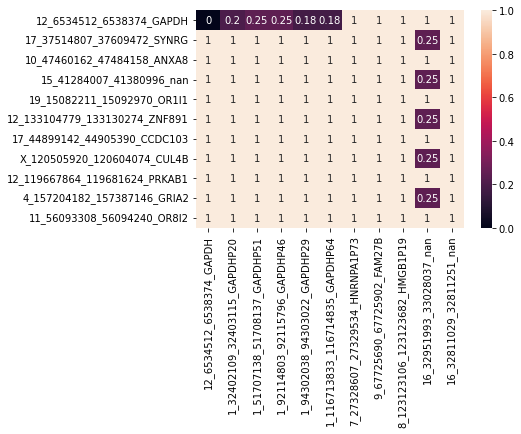

In [17]:
sns.heatmap(df, annot=True)

In [243]:
lev(psdg_gapdh_seq['1_32402109_32403115_GAPDHP20']["sequence"],psdg_gapdh_seq['12_6534512_6538374_GAPDH']["sequence"])

2869

In [18]:
def lev_dist(reference_seq_dict,query_seq_dict):
    dist_matrix = np.full((len(reference_seq_dict),len(query_seq_dict)),np.NaN)
    for refK,refI in zip(reference_seq_dict.keys(),range(0,len(reference_seq_dict))):
        for querK,querI in zip(query_seq_dict.keys(),range(0,len(query_seq_dict))):
            dist_matrix[refI,querI]=lev(reference_seq_dict[refK]["sequence"],query_seq_dict[querK]["sequence"])
    dist_df=pd.DataFrame(dist_matrix, index=reference_seq_dict.keys(),columns =query_seq_dict.keys())
    return dist_df

In [19]:
dist_df_test_gapdf_lev=lev_dist(codg_gapdh_seq,psdg_gapdh_seq)

In [20]:
dist_df_test_gapdf_lev

,12_6534512_6538374_GAPDH,1_32402109_32403115_GAPDHP20,1_51707138_51708137_GAPDHP51,1_92114803_92115796_GAPDHP46,1_94302038_94303022_GAPDHP29,1_116713833_116714835_GAPDHP64,7_27328607_27329534_HNRNPA1P73,9_67725690_67725902_FAM27B,8_123123106_123123682_HMGB1P19,16_32951993_33028037_nan,16_32811029_32811251_nan
12_6534512_6538374_GAPDH,0.0,2869.0,2872.0,2878.0,2888.0,2868.0,2943.0,3650.0,3286.0,72182.0,3640.0
17_37514807_37609472_SYNRG,90803.0,93659.0,93666.0,93672.0,93681.0,93663.0,93738.0,94453.0,94089.0,47335.0,94443.0
10_47460162_47484158_ANXA8,20134.0,22990.0,22997.0,23003.0,23012.0,22994.0,23069.0,23784.0,23420.0,53126.0,23774.0
15_41284007_41380996_nan,93127.0,95983.0,95990.0,95996.0,96005.0,95987.0,96062.0,96777.0,96413.0,48543.0,96767.0
19_15082211_15092970_OR1I1,7168.0,9753.0,9760.0,9766.0,9775.0,9757.0,9832.0,10547.0,10183.0,65285.0,10537.0
12_133104779_133130274_ZNF891,21633.0,24489.0,24496.0,24502.0,24511.0,24493.0,24568.0,25283.0,24919.0,51728.0,25273.0
17_44899142_44905390_CCDC103,3351.0,5242.0,5249.0,5255.0,5264.0,5246.0,5321.0,6036.0,5672.0,69796.0,6026.0
X_120505920_120604074_CUL4B,94292.0,97148.0,97155.0,97161.0,97170.0,97152.0,97227.0,97942.0,97578.0,49293.0,97932.0
12_119667864_119681624_PRKAB1,9950.0,12754.0,12761.0,12767.0,12776.0,12758.0,12833.0,13548.0,13184.0,62284.0,13538.0
4_157204182_157387146_GRIA2,179102.0,181958.0,181965.0,181971.0,181980.0,181962.0,182037.0,182752.0,182388.0,115022.0,182742.0


<AxesSubplot:>

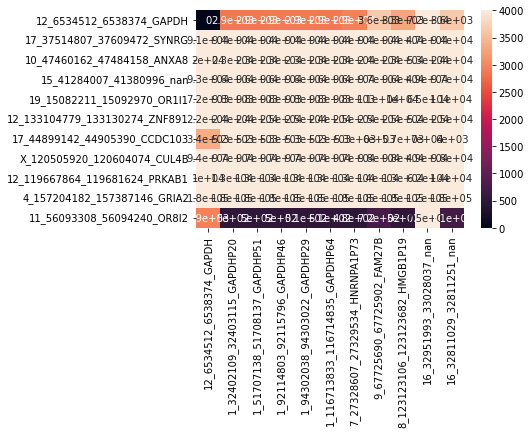

In [21]:
sns.heatmap(dist_df_test_gapdf_lev, annot=True, vmax=4000)

In [266]:
codg_gapdh_seq["2_153477338_153478762_RPRM"]["sequence"]

'AACGCTTAAATGTTGCATTTATTAAGGAAATGTTAAATAAGAAAAAAACAAAAAGTCAAAACGGTGTCACGGATGTCAAGAGCACTTTTGTGGCGTAAACCGTGCAGTCACGAGCTACGAGTTCTATTCTGGGTCTTTGTCCCAGGGCCAGCAGGAACGCTAGACGCCTCCCAAAAGACCCAGTGGGAAATGCACTAAAAGAAACAACTCACCCCGTTCAAATTCGCAGGCTCCCCCTCCCCCCACCCCTTCTCCCACAATGACAAAACTGTAACTCCTCAGGCAGGCAAACAGGCCACTGGGGCAGAAAAAGACTTATCAAACATTTGTATTCAAGCAAACAAACACAAAACCTCTTAAAACGGCACGTTACAATCAAAGGTATTTATCGCCCCTCCCCTCCAGGGCAGGGGGGGAGCAGGAGAAGAGTGGGAGCGCACCCGGACACGGATTTGTGAGACCCCATGAGTCTGCTGCGTGGCTTTTAACAGGTCACTCTTCCGGTCACAAGGCGATCAGTGCCGCTGGGTCTCTCCCCTGCCCGCCCTCTCCACCTGCCCCCAGAGCTTGGCCCACCTGCGGGTGGAGAAGGGCCTTCGCACCGTCGGTCTCCCCGCATTCCAAGTAAGTAGCAGCTTCCAAAGTTCTGCGCCCTAATCGCCCTCTTCTTGCCACTTTCTGCTGAGTTCAGAGTCTGGGCGCTCTCCTCCGACTGCCAGGCATGAGGACTTTCAGAGGGCGAGGGAGAAACCGGTCGCTTCTTTCCGAAAGGCCGAAGTCGAGAGAAATAATTGACTCCGACAGGTTTGCTTCGCCCAGTCTCTGATAGTGAGGGGCACAGCCGGGCTAGCAAAGTGGGCAGGCGTGGGAGCGGTTGCCGCGGGGGCAGAGGGCGGGTCAGTAGGGCCCCACGACCACCGCCTCCACCTCCTTAGACGGCCTCCGGTCCTTCACGAGGAAGTTGATCATGCCCTCGGACTTGATGAGCAGATTGCAGCC

In [268]:
psdg_gapdh_seq['1_32402109_32403115_GAPDHP20']["sequence"]

'TACTCCTAGGAGGCCATGTAGACCATAAGGTATATCGTTCTGTTGCTGTAGCCAAATTCATTGTCATATCAGGAAATGAGCTTGACAAAGTGGTCTTTGAGGGCAATGCCATTCCCAGCATTGAAGGTGGAAAAGGTGGGTGTCTCTGTTAAAGTTGGAGGAGGCAACCTGGTGCTCTGTGTAGCTCAGGAGGCCCTTGAGGGTGGCCTCCGATGCCAGTTTCACCACCTTCTTGATGTCATCATATTTGGGCAGCTCTCTCCAGATGGCAGATCAGGTCTACAACCCACATGTTGGCAGTGGAGACATGGAAGGCCATGCCAGTGGGCTTTCTGTTAAGCTCAGGGATGGCCTTGCCCACAGCCTTGGTAGAGTGGGTAAATGCAGGGATGATGTCCTGGAGAGTCCTGTGGCCATCACGCCACAGTTTCCCAGAGAGGCCATCCACAGTCTTCTGGGTGGCAATATTGGCACCAACTGTGGCCATGAGTCCCTCCATGATGCCAAAGTTGTCATGGATGACCTTGGGCAGGGCAGCTAAACAATTGGCAGTACAGGAAGCGTTGCTGACAATCACAAGGTTGTTTTCATACTTCTCAAGGTTCACGGCCATCACAAACATGGGGGCATCAACAGAGAGAGCAGATATGACCCTTTTGGTTGCACCCTCTAAGTGAGCCCCAGCCTTCTCCAAGGCAGTGAAGATGCCAGTGGACTTCATAACATAATCAGCGTCAGGACCAGCCCATTTGATTTTGATGGGATTTTGTTCCTGGAAGATGGTGATGGGATTTCCATTGGTGACAAACTTCTTGTTCTTAGCCTTGATGGTGCCTTGGAACTTGTCATGGGTGGAGTCATACTAGAACATGTAGACCATGGAGTTGACCTGAATGAAGTGGTCATAGATGGTGACACTATCCACTTTGCTAGAGTTAAAAGCAGCCCTGGTAAACAGGCTTCCAATATGGTCCCATCTATTTACTCTGGCCTTCACTC

In [269]:
lev("AAC------GCTTAAATGT-------","TACTCCTAGGAGGCCATGTAGACCAT")

19

In [270]:
lev("AACGCTTAAATGT","TACTCCTAGGAGGCCATGTAGACCAT")

16

In [41]:
rprm="--------------------AAC----GCTTAAATGTTGCATTTATTAAGGAAATGTTAAATAAGAAAAAAACAAAAAGTCAAAACGGTGTCACGGATGTCAAGAGCACTTTTGTGGCGTAAACCGTGCAGTCACGAGCTACGAGTTCTATTCTGGGTCTTTGTCCCAGGGCCAGCAGGAACGCTAGACGCCTC----CCAAAAGACCCAGTGGGAAATGCACTAAAAGAAACAACTCACCCCGTTCAAATTCGCAGGCTCCCCCTCCCCCCACCCCTTCTCCCACAATGACAAAACTGTAACTCCTCAGGCAGGCAAACAGGCCACTGGGGCAGAAAAAGAC---TTATCAAACATTTGTATTCAAGCAAACAAACACAAAACCTCTTAAAACGGCACGTTACAATCAAAGGTATTTATCGCCCCTCCCCTCCAGGGCAGGGGGGGAGCAGGAGAAGAGTGGGAG-CGCACCCGGACACGGATTTGT--AGCTTGGCCCACCTGCGGGTGGAGAAGGGCCTTCGCACCGTCGGTCTCCCCGCATTCCAATCACAAGGCGATCAGTGCCGCTGGGTCTCTCCCCTGCCCGCCCTCTCCACCTGCCCCCAGGAGACCCCATGAGTCTGCTGCGTGGCTTTTAACAGGTCACTCTT--CCGGGTAAGTAGCAGCTTCCAAAGTTCTGCGCCCTAATCGCCCTCTTCTTGCCACTTTCTGCTGAGTTCAGAGTCTGGGCGCTCTCCTCCGACTGCCAGGCATGAGGACTTTCAGAGGGCGAGGGAGAAACCGGTCGCTTCTTTCCGAAAGGCCGAAGTCGAGAGAAATAATTGACTCCGACA----GGTTTGCTTCGCCCAGTCTCTGATAGTGAGGGGCACAGCCGGGCTAGCAAAGTGGGCAGGCGTGGGAGCGGTTGCCGCGGGGGC--AGAGGGCGGGTCAGTAGGGCCCCACGACCACCGCCTCCACCTCCTTAGACGG------------------------CCTCCGGTCCTTCACGAGGAAGTTGATCATGCCCTCGGACTTGATGAGCAGATTGCAGCCGAGGAAGAAGATGCCGAAGACCACGGTGAGTGAGAGCACGCACATGACCGCGATCTGCACCACGCGCATTATGTACAGGCTACGCTCGTCCGGGCCTCCCTCCGCGAAGCCGTCGTCGGTCACCACGGACGCCTGGGTGCAGCAGCGCACGGCTCGCTCCAGCGCCTCGCTGCTGTTGGCCAGGAACAGGCCCGCCACGTCCGTCTGGTTGCCTAGGGCCGGATTCATCGCAGGAACGGGCGGGCGCCGCGAGCGGCGCGGGTCCGAGGGGTGGGAAGGCGGCGGCGCTGGAGGAACAGGTGCCGGGCTGAGCGCTCACTCGCAGACTAGCGCGTGCGAGGGCTCCTCGCTCTGCTTTCGAAAGTCCCTGGGCCGTGGGAGTTTCCCAGGAGCCTCTCCGACGCGCGCAGCAGCTAGGCTCTTCT"

In [42]:
p20="TACTCCTAGGAGGCCATGTAGACCATAAGGTATATCGTTCTGTTGCTGTAGCCAAATTCATTGTCATATCAGGAAATG--------------A-GCTTGACAAAGTGGTCTTTGAGGGCAATGCCATTCCCAGCATTGAAGGTGGAAAAGGTGGGTGTCTCTGTTAAAGTTGGAGGAGGCAACCTGGTGCTCTGTGTAGCTCAGGAGGCCCTTGAGGGTGGCCTCCGATGCCAGTTTCACCACCTTCTTGAT-------------------------------------GT---CATCATATTTGGGCAGCTC--------TCTCCAGATGGCAGATCAGGTCTACAACCCACATGTTGGCAGTGGAGACATGGAAGGCCATGCCAG--TGGGCTTTCTGTTAAGCTCAGGGATGGCCTTGCCCACAGCCTTGGT----------AGAGTGGGTAAATGCAGGGATGATGTCCTGGAGAGTCCTGTGGCCATCACGCCACAGTTTCCCAGAGAGGCCATCCACAGTCTTCTGGGTGGCAATATTGGCACCAACTGTGGCCATGAGTCCCTCCA------------------TGATGCCA-AAGTTGTCATGGATGACCTTGGGCAG-------------------------GGCAGCTAAACAATTGGCAGTACAGGAAGCGTTGCTG-ACAATCACAAGGTTGTTTTCATACTTCTCAAGGTTCA------CGGCC-----------ATCACAAACATGGGGGCATCAACAGAGAGAGCAGAT-ATG--ACCCTTTTGGTTGCACCCTCTAAG-TGAGCCCCAGCCTTCTCCAAGGCAGTGAAGATGCCAGTGGACTTCATAACATAATCAGCGTCAGGACCAGCCC-----ATTTGATTTTGATGGGATTTTGTTCCTGGAAGATGGTGATGGGATTTCCATTGG---------TGACAAACTTCTTGTTCTTAGCCTTGATGGTGCCTTGGAACTTGTCATGGGTGGAGTCATACTAGAACATGTAGACCATGGAGTTGACCTGAAT---------GAAGTGGTCATAGATGGTGACACTATCCACTTTGCTAGAGTTA---------------------AAAGCAGCCCTGGTAAACAGGCTTCCAATATGGTCCCATCTATTTACTCTGGCCTTCACTCACACCAT-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------"

In [274]:
lev(rprm,p20)

1029

In [36]:
def align_lev_dist(reference_seq_dict,query_seq_dict):
    dist_matrix = np.full((len(reference_seq_dict),len(query_seq_dict)),np.NaN)
    score_matrix=np.full((len(reference_seq_dict),len(query_seq_dict)),np.NaN)
    for refK,refI in zip(reference_seq_dict.keys(),range(0,len(reference_seq_dict))):
        for querK,querI in zip(query_seq_dict.keys(),range(0,len(query_seq_dict))):
            alignments = pairwise2.align.globalxx(Seq(reference_seq_dict[refK]["sequence"]), Seq(query_seq_dict[querK]["sequence"]),one_alignment_only=True)
            alignment=alignments[0]
            dist_matrix[refI,querI]=lev(alignment.seqA,alignment.seqB)
            score_matrix[refI,querI]=alignment.score
            del alignments
            print(refI,querI)
    dist_df=pd.DataFrame(dist_matrix, index=reference_seq_dict.keys(),columns =query_seq_dict.keys())
    score_df=pd.DataFrame(score_matrix, index=reference_seq_dict.keys(),columns =query_seq_dict.keys())
    return dist_df,score_df

In [26]:
#codg_gapdh_seq2=codg_gapdh_seq["12_6534512_6538374_GAPDH","11_56093308_56094240_OR8I2"]
codg_gapdh_seq2=dict((k, codg_gapdh_seq[k]) for k in ("12_6534512_6538374_GAPDH","11_56093308_56094240_OR8I2"))

In [37]:
align_dist_df_test_gapdf_lev,score_test_gapdh=align_lev_dist(codg_gapdh_seq2,psdg_gapdh_seq)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10


<AxesSubplot:>

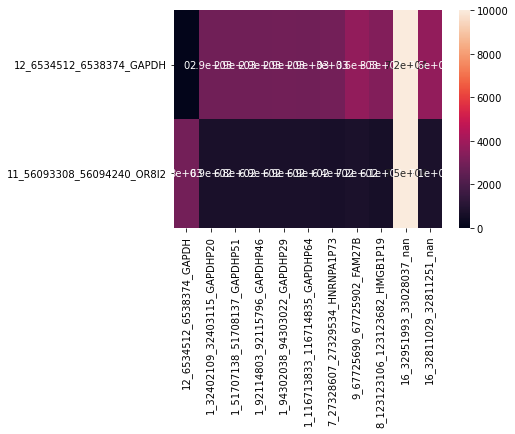

In [38]:
sns.heatmap(align_dist_df_test_gapdf_lev, annot=True, vmax=10000)# may be results should be varified with score? bigger score - true?

In [39]:
score_test_gapdh

,12_6534512_6538374_GAPDH,1_32402109_32403115_GAPDHP20,1_51707138_51708137_GAPDHP51,1_92114803_92115796_GAPDHP46,1_94302038_94303022_GAPDHP29,1_116713833_116714835_GAPDHP64,7_27328607_27329534_HNRNPA1P73,9_67725690_67725902_FAM27B,8_123123106_123123682_HMGB1P19,16_32951993_33028037_nan,16_32811029_32811251_nan
12_6534512_6538374_GAPDH,3862.0,994.0,990.0,984.0,975.0,994.0,919.0,212.0,576.0,3862.0,222.0
11_56093308_56094240_OR8I2,922.0,625.0,623.0,616.0,613.0,623.0,606.0,212.0,451.0,932.0,222.0


In [56]:
from Bio.pairwise2 import format_alignment 

In [ ]:
#I don't think there is a bug here. What you are trying to do will take a huge amount of memory; this causes the MemoryError with Bio.pairwise2. The PairwiseAligner in Bio.Align is more memory-efficient and can perform this alignment in principle, 

In [95]:
def align_hamm_dist(reference_seq_dict,query_seq_dict):
    dist_matrix = np.full((len(reference_seq_dict),len(query_seq_dict)),np.NaN)
    score_matrix=np.full((len(reference_seq_dict),len(query_seq_dict)),np.NaN)
    for refK,refI in zip(reference_seq_dict.keys(),range(0,len(reference_seq_dict))):
        for querK,querI in zip(query_seq_dict.keys(),range(0,len(query_seq_dict))):
            alignments = pairwise2.align.globalxx(Seq(reference_seq_dict[refK]["sequence"]), Seq(query_seq_dict[querK]["sequence"]),one_alignment_only=True)
            alignment=alignments[0]
            dist_matrix[refI,querI]=hamming(list(alignment.seqA),list(alignment.seqB))
            score_matrix[refI,querI]=alignment.score
            del alignments
            print(refI,querI)
    dist_df=pd.DataFrame(dist_matrix, index=reference_seq_dict.keys(),columns =query_seq_dict.keys())
    score_df=pd.DataFrame(score_matrix, index=reference_seq_dict.keys(),columns =query_seq_dict.keys())
    return dist_df,score_df

In [96]:
Halign_dist_df_test_gapdf_lev,Hscore_test_gapdh=align_hamm_dist(codg_gapdh_seq2,psdg_gapdh_seq)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10


<AxesSubplot:>

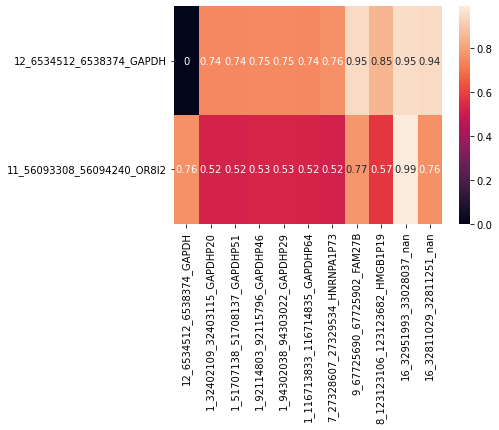

In [97]:
sns.heatmap(Halign_dist_df_test_gapdf_lev, annot=True)#, vmax=10000)